# Objective

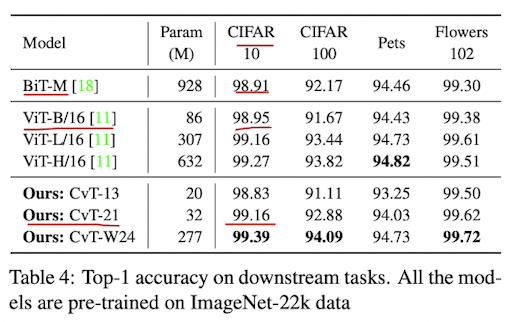

- Verify the performance of the CvT model by running the downstream task for CIFAR-10
- CvT-21 Model is pre-trained on ImageNet-22k
- As a result of the experiment, CvT showed the best performance even though it took less training time.

## All of these codes are not in the paper except for the 'Define Model' part. To verify the paper's experiment, I reproduced the codes by referring to the content learned in this course and the codes in the references.

## How to fine-tuning the model

Fine-tuning takes a long time. 

Thus, we repeated training: load model, train five epochs and save model

There are some {epoch.pth} files per model. 
- models (folder): BiT-M-{N}epoch.pth, ViT-L-{N}epoch.pth, CvT-21-{N}epoch.pth

As a result, we trained each model for 15 epochs.

## Setup Environment

- In A100-SXM4-40GB, this notebook doens't work because of the GPU...
- If you use Colab Pro+, please check the allocated GPU


In [ ]:
!nvidia-smi

Sun May 22 10:09:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import sys

sys.path.append('/root/.local/lib/python3.7/site-packages')
sys.path.append('/content/gdrive/MyDrive/FinalProject/CvT-main/lib')

for pth in sys.path:
  print(pth)


/content
/env/python
/usr/lib/python37.zip
/usr/lib/python3.7
/usr/lib/python3.7/lib-dynload
/usr/local/lib/python3.7/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.7/dist-packages/IPython/extensions
/root/.ipython
/root/.local/lib/python3.7/site-packages
/content/gdrive/MyDrive/FinalProject/CvT-main/lib


In [ ]:
!pip install torch==1.7.1 torchvision==0.8.2 torchaudio==0.7.2
!pip install -U PyYAML
!pip install tensorboardX 
!pip install yacs
!pip install timm
!pip install einops
!pip install tensorwatch
!pip install ptflops

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data


import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

import time

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Load Data (CIFAR-10)

In [ ]:
batch_size = 8
num_classes = 10
num_epochs = 5

pre_epochs = 10 # epochs to start training

In [ ]:
train_transforms = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                ])
train_set = torchvision.datasets.CIFAR10("./", train=True, 
                                         download=True, 
                                         transform=train_transforms)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

0it [00:00, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./


In [ ]:
test_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

test_set = torchvision.datasets.CIFAR10("./", train=False, 
                                        download=True, 
                                        transform=test_transforms)

test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [ ]:
batch = next(iter(train_loader))

images, labels = batch

print(images.shape)
print(labels)

torch.Size([8, 3, 224, 224])
tensor([3, 8, 5, 8, 9, 5, 7, 1])


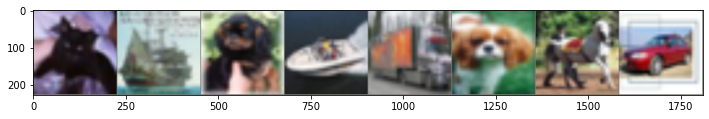

	cat 	ship 	dog 	ship 	truck 	dog 	horse 	car


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
# Inverse the normalisation
def inverse_normalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def imshow(img):
    img = inverse_normalize(tensor=img, mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))  
    npimg = img.numpy()
    plt.figure(figsize=(12,12))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(classes[labels[j]]) for j in range(batch_size)))

## Define Model

 - We modified the CvT file.
 - So, Please use the modified file in our drive (/content/gdrive/MyDrive/FinalProject/CvT-main)
 - When you download this folder, please save in /content/gdrive/MyDrive/FinalProject
 

In [ ]:
cd /content/gdrive/MyDrive/FinalProject/CvT-main

/content/gdrive/MyDrive/FinalProject/CvT-main


In [ ]:
from __future__ import absolute_import # make py3 grammer available for py2
from __future__ import division
from __future__ import print_function

import argparse
import logging
import os
import pprint
import time

import torch.nn.parallel
import torch.optim
from torch.utils.collect_env import get_pretty_env_info
from tensorboardX import SummaryWriter
import torchvision.transforms as transforms

from tools import _init_paths
from config import config
from config import update_config
from config import save_config
from core.loss import build_criterion
from core.function import train_one_epoch, test
from dataset import build_dataloader
from models import build_model
from optim import build_optimizer
from scheduler import build_lr_scheduler
from utils.comm import comm
from utils.utils import create_logger
from utils.utils import init_distributed
from utils.utils import setup_cudnn
from utils.utils import summary_model_on_master
from utils.utils import resume_checkpoint
from utils.utils import save_checkpoint_on_master
from utils.utils import save_model_on_master

# ---------------- Own Code --------------------
class Args:
  def __init__(self, cfg, local_rank, port, opts):
    self.cfg = cfg
    self.local_rank = local_rank
    self.port = port
    self.opts = opts

cfg = 'experiments/imagenet/cvt/cvt-21-224x224.yaml'
opts = []

args = Args(cfg, 0, 9000, opts)
# ----------------------------------------------

init_distributed(args) # set num_gpus, distributed and specify the gpu to use (local_rank)
setup_cudnn(config) # set cudnn

update_config(config, args) # update config from yaml file, arguments, and default
final_output_dir = create_logger(config, args.cfg, 'train')
tb_log_dir = final_output_dir

if comm.is_main_process():
    output_config_path = os.path.join(final_output_dir, 'config.yaml')
    save_config(config, output_config_path)

model = build_model(config)

## Store the pth file in FineTuning folder (not in CvT folder)
 - maintain the pth file (of ViT, BiT, CvT) in the same folder!

In [ ]:
cd /content/gdrive/MyDrive/FinalProject/FineTuning

/content/gdrive/MyDrive/FinalProject/FineTuning


## Load the Previously Trained Model & Restruct the Last Layer
 - The last output must be 10
 - ImageNet-22k, 224x24, Pre-trained model CvT-21

In [ ]:
# Last layer of model
model.head

Linear(in_features=384, out_features=1000, bias=True)

 - If Start Epoch is 0

In [ ]:
# If start epoch is 0

if pre_epochs ==0:
    # Pre-trained on ImageNet 22k
    PATH = '/content/gdrive/MyDrive/FinalProject/CvT-main/CvT-21-384x384-IN-22k.pth'

    # apply the paramters to model (out_features = 1000)
    model.load_state_dict(torch.load(PATH))
    model = model.to(device)

    # change out_features: 1000 to 10
    in_features = model.head.in_features
    model.head = nn.Linear(in_features, num_classes, bias= True)
    model = model.to(device)

 - If Start Epoch is bigger than 0

In [ ]:
# If start epoch is not 0

if pre_epochs > 0:
# load trained model before
    PATH = f'./models/CvT-{pre_epochs}epoch.pth'

    # replace the final output layer with new one (to apply the pre-trained model which is epoch > 0)
    # change out_features: 1000 to 10
    in_features = model.head.in_features
    model.head = nn.Linear(in_features, num_classes, bias= True)

    # apply the paramters to model
    model.load_state_dict(torch.load(PATH))
    model = model.to(device)

## Fine Tuning Strategy
 - In situations where there are many classes in downstream task, problems with low performance can occur

 - When the number of labels for the target task is large, perform backpropagation on every feature extractor will be better.

 - To obtaion the high accuracy, we finetuned on full layers
 - https://wandb.ai/suvadeep/pytorch/reports/Finetuning-of-ResNet-18-on-CIFAR-10-Dataset--VmlldzoxMDE2NjQ1
 - https://androidkt.com/pytorch-freeze-layer-fixed-feature-extractor-transfer-learning/
 - https://androidkt.com/modify-pre-train-pytorch-model-for-finetuning-and-feature-extraction/

In [ ]:
params_to_update = []

# Check unfreezed layer
for name, param in model.named_parameters():
  if param.requires_grad == True:
    params_to_update.append(param)
    print(name) # param to update. (it is same to whole parameters in model)


# Loss and Optimiser
criterion = nn.CrossEntropyLoss()
opt = torch.optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

In [ ]:
# (number of images, number of output classes)
model(images.to(device)).shape

torch.Size([8, 10])

## Train (Fine Tuning)

In [ ]:
n_total_steps = len(train_set)
n_iterations = -(-n_total_steps // batch_size) 
print(f'Total steps: {n_total_steps}')
print(f'Iterations per epoch: {n_iterations}')

start = time.time()

# iterate 'pre_epoch' to 'pre_epoch + num_epohcs'
for epoch in range(pre_epochs, num_epochs + pre_epochs):
  print("\n")
  for i, (images, labels) in enumerate(train_loader):
    model.train()                               

    images = images.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = model(images)                         
    loss = criterion(outputs, labels)               

    # Backward pass and Optimise
    opt.zero_grad()
    loss.backward()
    opt.step()

    # Print
    if (i+1) % ((n_total_steps//batch_size)//5) == 0:
      print(f'Epoch {epoch+1}/{num_epochs + pre_epochs}, Iteration {i+1}/{n_iterations}, Loss={loss.item()} ')

fine_tuning_time = time.time() - start

Total steps: 50000
Iterations per epoch: 6250


Epoch 11/15, Iteration 1250/6250, Loss=1.072882469088654e-06 
Epoch 11/15, Iteration 2500/6250, Loss=2.9652965167770162e-06 
Epoch 11/15, Iteration 3750/6250, Loss=0.005319166462868452 
Epoch 11/15, Iteration 5000/6250, Loss=1.5332825569203123e-05 
Epoch 11/15, Iteration 6250/6250, Loss=0.0006180669879540801 


Epoch 12/15, Iteration 1250/6250, Loss=0.00012598605826497078 
Epoch 12/15, Iteration 2500/6250, Loss=4.768368739860307e-07 
Epoch 12/15, Iteration 3750/6250, Loss=2.831218921528489e-07 
Epoch 12/15, Iteration 5000/6250, Loss=0.00018131175602320582 
Epoch 12/15, Iteration 6250/6250, Loss=2.2633103071711957e-05 


Epoch 13/15, Iteration 1250/6250, Loss=0.010062300600111485 
Epoch 13/15, Iteration 2500/6250, Loss=0.0001732780656311661 
Epoch 13/15, Iteration 3750/6250, Loss=1.0430776455905288e-06 
Epoch 13/15, Iteration 5000/6250, Loss=4.723590791400056e-06 
Epoch 13/15, Iteration 6250/6250, Loss=8.289876132039353e-05 


Epoch 14/15,

## Test

In [ ]:
# Formating Function
def nFormat(n):
    s = str(n)
    result = ""
    while True:
        if len(s) > 3:
            result = "," + s[-3:] + result
            s = s[:-3]
        else:
            result = s + result
            break
    return result

def tFormat(n):
    n = int(n)
    second = n%60
    minute = n//60
    return f'{minute}m {second}s'

In [ ]:
print('Final Epochs=',pre_epochs+num_epochs)
start = time.time()

with torch.no_grad():
  n_correct = 0
  n_samples = 0
  n_class_correct = [0 for i in range(10)]
  n_class_samples = [0 for i in range(10)]


  model.eval()
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images) 

    # Get predictions
    _, y_preds = torch.max(outputs, 1)
    n_samples += labels.size(0)
    n_correct += (y_preds == labels).sum().item()

    # Keep track of each class
    for i in range(batch_size):
      label = labels[i]
      pred = y_preds[i]
      if (label == pred):
        n_class_correct[label] += 1
      n_class_samples[label] += 1

  # Print accuracy
  acc = 100.0 * n_correct / n_samples
  print(f'Test Accuracy of the WHOLE CNN = {acc} %')

  for i in range(len(classes)):
    acc = 100.0 * n_class_correct[i] / n_class_samples[i]
    print(f'Accuracy of {classes[i]}: {acc} %')

test_time = time.time() - start

Final Epochs= 15
Test Accuracy of the WHOLE CNN = 97.02 %
Accuracy of plane: 96.6 %
Accuracy of car: 97.2 %
Accuracy of bird: 97.2 %
Accuracy of cat: 93.1 %
Accuracy of deer: 98.2 %
Accuracy of dog: 95.2 %
Accuracy of frog: 97.7 %
Accuracy of horse: 98.0 %
Accuracy of ship: 98.9 %
Accuracy of truck: 98.1 %


In [ ]:
print('Number of Parameters: ',nFormat(sum(p.numel() for p in model.parameters())))
print('Fine-tuning Time per 5 epoch: ',tFormat(fine_tuning_time))
print('Test Time: ',tFormat(test_time))

Number of Parameters:  31,241,546
Fine-tuning Time per 5 epoch:  94m 48s
Test Time:  0m 56s


## Save Model

In [ ]:
PATH = f'./models/CvT-{pre_epochs + num_epochs}epoch.pth'
torch.save(model.state_dict(), PATH)

## Check the Load and Save Correctly
 - To verify the loading weights from .pth file correctly, reload the model and test it!
 - The test accuarcy must exactly same.

In [ ]:
# reload the init model
model = build_model(config)

In [ ]:
# restruct the final output layer of init model
in_features = model.head.in_features
model.head = nn.Linear(in_features, num_classes, bias= True)

# load the saved weights on the above
model.load_state_dict(torch.load(PATH))
model = model.to(device)

In [ ]:
with torch.no_grad():
  n_correct = 0
  n_samples = 0
  n_class_correct = [0 for i in range(10)]
  n_class_samples = [0 for i in range(10)]


  model.eval()
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images) 

    # Get predictions
    _, y_preds = torch.max(outputs, 1)
    n_samples += labels.size(0)
    n_correct += (y_preds == labels).sum().item()

    # Keep track of each class
    for i in range(batch_size):
      label = labels[i]
      pred = y_preds[i]
      if (label == pred):
        n_class_correct[label] += 1
      n_class_samples[label] += 1

  # Print accuracy
  acc = 100.0 * n_correct / n_samples
  print(f'Test Accuracy of the WHOLE CNN = {acc} %')

  for i in range(len(classes)):
    acc = 100.0 * n_class_correct[i] / n_class_samples[i]
    print(f'Accuracy of {classes[i]}: {acc} %')

Test Accuracy of the WHOLE CNN = 97.02 %
Accuracy of plane: 96.6 %
Accuracy of car: 97.2 %
Accuracy of bird: 97.2 %
Accuracy of cat: 93.1 %
Accuracy of deer: 98.2 %
Accuracy of dog: 95.2 %
Accuracy of frog: 97.7 %
Accuracy of horse: 98.0 %
Accuracy of ship: 98.9 %
Accuracy of truck: 98.1 %


# Result
###CvT-21
 - Accuracy: 97.2%
 - Train Time: 94m 48s
 - Parameters: 31,241,546

###ViT-B-16
 - Accuracy: 96.18%
 - Train Time: 79m 44s
 - Parameters: 85,806,346

###BiT-M-R50x3
 - Accuracy: 96.26%
 - Train Time: 188m 20s
 - Parameters: 211,235,530

##References
- https://github.com/microsoft/CvT
- https://arxiv.org/abs/2103.15808